Resultados de las 5 mejores combinaciones de C:
       param_C  mean_test_score  std_test_score  mean_train_score  \
8     1.128838         0.762520        0.023223          0.790778   
12  379.269019         0.750641        0.076068          0.868777   
7     0.263665         0.750175        0.030408          0.778228   
9     4.832930         0.744118        0.044428          0.815729   
11   88.586679         0.738062        0.064044          0.859431   

    std_train_score  
8          0.035372  
12         0.007168  
7          0.026049  
9          0.026199  
11         0.019840  

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': np.float64(1.1288378916846884)} : 0.7625203820172374 accuracy


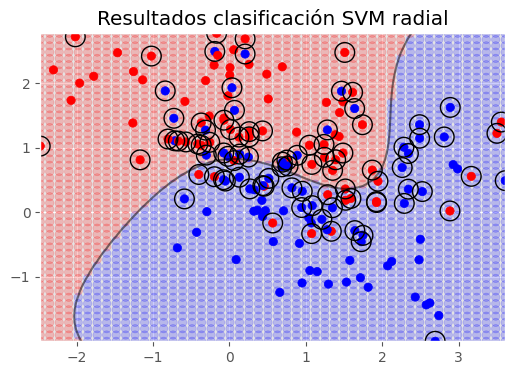

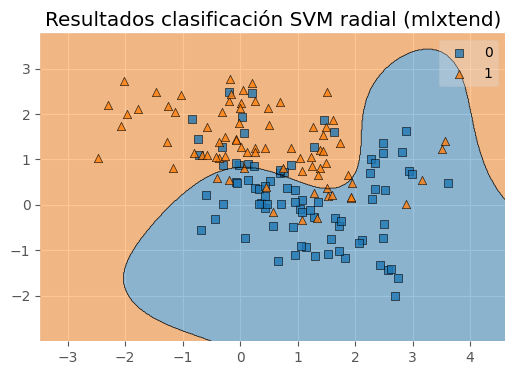


----------------------------------------
El accuracy de test es: 80.00%
----------------------------------------

Matriz de Confusión:
Predicción   0   1
Real              
0           14   3
1            5  18


In [12]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions # Necesaria para la visualización simplificada

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# 1. CARGA Y PREPARACIÓN DE DATOS (Necesario para que el resto funcione)
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
         + 'Estadistica-machine-learning-python/master/data/ESL.mixture.csv'
datos = pd.read_csv(url)

X = datos.drop(columns = 'y')
y = datos['y']

# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
                                             X,
                                             y, # y debe ser un vector 1D
                                             train_size   = 0.8,
                                             random_state = 1234,
                                             shuffle      = True
                                         )
# 2. BÚSQUEDA DEL MEJOR HIPERPARÁMETRO C CON KERNEL RADIAL
# ==============================================================================
# Grid de hiperparámetros: Prueba 20 valores de C en escala logarítmica
param_grid = {'C': np.logspace(-5, 7, 20)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        estimator  = SVC(kernel= "rbf", gamma='scale'), # Se especifica kernel='rbf'
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3,
        verbose    = 0,
        return_train_score = True
      )

# Se entrena el modelo de búsqueda de rejilla
grid.fit(X = X_train, y = y_train)

# 3. RESULTADOS DE LA BÚSQUEDA
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)

print("Resultados de las 5 mejores combinaciones de C:")
# Mostrar las 5 mejores combinaciones
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5))

print("\n----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

# Asignar el mejor estimador (modelo)
modelo = grid.best_estimator_


# 4. REPRESENTACIÓN GRÁFICA DE LÍMITES DE CLASIFICACIÓN
# ==============================================================================
# Grid de valores para dibujar el fondo
x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
y_grid = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
Y, X_grid = np.meshgrid(y_grid, x)
grid_points = np.vstack([X_grid.ravel(), Y.ravel()]).T

# Predicción valores grid para colorear el fondo
pred_grid = modelo.predict(grid_points)

fig, ax = plt.subplots(figsize=(6,4))

# Fondo (predicciones del grid)
ax.scatter(grid_points[:,0], grid_points[:,1], c=pred_grid, alpha = 0.2)
# Datos de entrenamiento (puntos originales)
ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

# Vectores soporte
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=200, linewidth=1,
    facecolors='none', edgecolors='black')

# Hiperplano de separación (solo el nivel 0)
ax.contour(
    X_grid,
    Y,
    modelo.decision_function(grid_points).reshape(X_grid.shape),
    colors='k',
    levels=[0],
    alpha=0.5,
    linestyles='-')

ax.set_title("Resultados clasificación SVM radial");
plt.show() # Mostrar el gráfico generado manualmente

# 5. REPRESENTACIÓN GRÁFICA USANDO MLXTEND
# ==============================================================================
fig, ax = plt.subplots(figsize=(6,4))
plot_decision_regions(
    X = X_train.to_numpy(),
    y = y_train.to_numpy().astype(np.integer), # Asegurar tipo integer
    clf = modelo,
    ax = ax)
ax.set_title("Resultados clasificación SVM radial (mlxtend)");
plt.show() # Mostrar el gráfico de mlxtend

# 6. EVALUACIÓN FINAL
# ==============================================================================
# Predicciones test
predicciones = modelo.predict(X_test)

# Accuracy de test del modelo
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("\n----------------------------------------")
print(f"El accuracy de test es: {100*accuracy:.2f}%")
print("----------------------------------------")

# Matriz de confusión de las predicciones de test
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predicciones,
    rownames=['Real'],
    colnames=['Predicción'])

print("\nMatriz de Confusión:")
print(confusion_matrix)